# Add Folders to Path

We start by adding the necessary folders to the current working path.

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add FTLE folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/FTLE")

CPU times: user 267 µs, sys: 207 µs, total: 474 µs
Wall time: 339 µs


# Overview

In the following notebook we evaluate the Finite-Time-Lyapunov-Exponent (FTLE) on a two-dimensional, satellite-altimetry-derived ocean-surface current product (AVISO). The notebook is structured as follows:

1. Import data from the file 'AVISO.mat' stored in the folder 'data'.
<br />
2. Define computational parameters (such as the number of cores) and data.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from (discrete) gridded data.
 <br />
5. Finite Time Lyapunov Exponent (FTLE):

    * Compute gradient of flow map $ \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0) $ over meshgrid using an auxiliary grid. 
    
    * Compute Cauchy Green (CG) strain tensor as: 
    
    \begin{equation} \mathbf{C}_{t_0}^{t_N}(\mathbf{x}_0) = \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0)^T\mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0). \end{equation}
   
    * Compute maximum eigenvalues $ \lambda_2(\mathbf{x}_0) $ of $ \mathbf{C}_{t_0}^{t_N}(\mathbf{x}_0) $.
    
    * Compute FTLE as:
    
    \begin{equation}
    \mathrm{FTLE}_{t_0}^{t_N}(\mathbf{x}_0) = \dfrac{1}{|t_N-t_0|} \log(\sqrt{\lambda_2(\mathbf{x}_0)}).
    \end{equation}

# Import Data

In [2]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/Aviso/AVISO.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time_data = mat_file['t']

CPU times: user 204 ms, sys: 46.6 ms, total: 250 ms
Wall time: 252 ms


# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
import numpy as np

# number of cores to be used for parallel computing
Ncores = 18

# time resolution of data
dt_data = time_data[0, 1]-time_data[0,0]

# periodic boundary conditions
periodic_x = False
periodic_y = False
periodic = [periodic_x, periodic_y]

# unsteady velocity field
bool_unsteady = True

# defined domain
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## compute meshgrid of dataset
X, Y = np.meshgrid(x, y)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
%%time
# Initial time (in days)
t0 = 0

# Final time (in days)
tN = 25

# time step-size (in days)
dt = .1

# NOTE: In case of computing the backward FTLE field tN < t0 and dt < 0!!!!!

time = np.arange(t0, tN+dt, dt)

# length of time interval (in days)
lenT = abs(tN-t0)

# longitudinal and latitudinal boundaries (in degrees)
xmin = -3
xmax = 1
ymin = -32
ymax = -24

# make sure that the chosen domain is part of the data domain
assert (xmax <= np.max(X) and xmin >= np.min(X) and ymin >= np.min(Y) and ymax <= np.max(Y) and t0 >= np.min(time_data) and tN <= np.max(time_data)),"The domains you are chooising are outside the domain of the data!!!!! --> redefine spatial/temporal domain"

# spacing of meshgrid (in degrees)
dx = 0.01
dy = 0.01

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

CPU times: user 2.46 ms, sys: 3.15 ms, total: 5.61 ms
Wall time: 4.04 ms


# Velocity Interpolation

In order to evaluate the velocity field at arbitrary locations and times, we interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear".

In [5]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# set nan values to zero so that we can apply interpolant. Interpolant does not work if the array contains nan values
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, time_data, method = "cubic")

CPU times: user 89.4 ms, sys: 24.8 ms, total: 114 ms
Wall time: 115 ms


# Finite-Time Lyapunov Exponent (FTLE)

Next, we compute the FTLE over the meshgrid over the given time-interval.
We iterate over all initial conditions and first calculate the gradient of the flow map using an auxiliary grid. 'aux_grid' specifies the ratio between the auxiliary grid and the original meshgrid. This parameter is generally chosen to be between $ \left[\dfrac{1}{10}, \dfrac{1}{5}\right] $. Subsequently, we compute the Cauchy Green strain tensor. From the maximum eigenvalue of the Cauchy-Green strain tensor we can then compute the FTLE. The iteration over the meshgrid is parallelized.

In [6]:
%%time
# Import gradient of flow map
from ipynb.fs.defs.gradient_flowmap import gradient_flowmap

# Import package which checks particle location
from ipynb.fs.defs.check_location import check_location

# Import package for progress bar
from tqdm.notebook import tqdm

# Import package for parallel computing
from joblib import Parallel, delayed

# Import package for computing CauchyGreen (CG) strain tensor
from ipynb.fs.defs.CauchyGreen import CauchyGreen

# Import package for computing Finite-Time Lyapunov Exponent (FTLE)
from ipynb.fs.defs.FTLE import _FTLE

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .2 # [1/5, 1/100]
aux_grid = [np.around(aux_grid_ratio*(X_domain[0, 1]-X_domain[0, 0]), 5), np.around(aux_grid_ratio*(Y_domain[1, 0]-Y_domain[0, 0]), 5)]

# parallel computation of FTLE over meshgrid.
def parallel_FTLE(i):
    
    FTLE_parallel = X_domain[0,:].copy()*np.nan
    
    for j in range(X_domain.shape[1]):
        
        # set initial condition
        x = np.array([X_domain[i, j], Y_domain[i, j]])
        
        # only compute FTLE for trajectories starting region where velocity field is defined
        if check_location(X, Y, defined_domain, x)[0] == "IN":
    
            # compute gradient of flow map from finite differencing 
            gradFmap = gradient_flowmap(time, x, X, Y, Interpolant, periodic, defined_domain, bool_unsteady, dt_data, delta, aux_grid)
        
            # gradFmap has shape (2, 2, len(time)) --> we need gradient of flow map from t0 to tN
            gradFmap_t0_tN = gradFmap[:,:,-1]
        
            # compute CG
            C = CauchyGreen(gradFmap_t0_tN)
            
            # compute FTLE from CG
            FTLE_parallel[j] = _FTLE(C, lenT)
        
    return FTLE_parallel

FTLE = np.array(Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_FTLE)(i) for i in tqdm(range(X_domain.shape[0]))))

  0%|          | 0/802 [00:00<?, ?it/s]

CPU times: user 14.4 s, sys: 5.12 s, total: 19.5 s
Wall time: 18min 59s


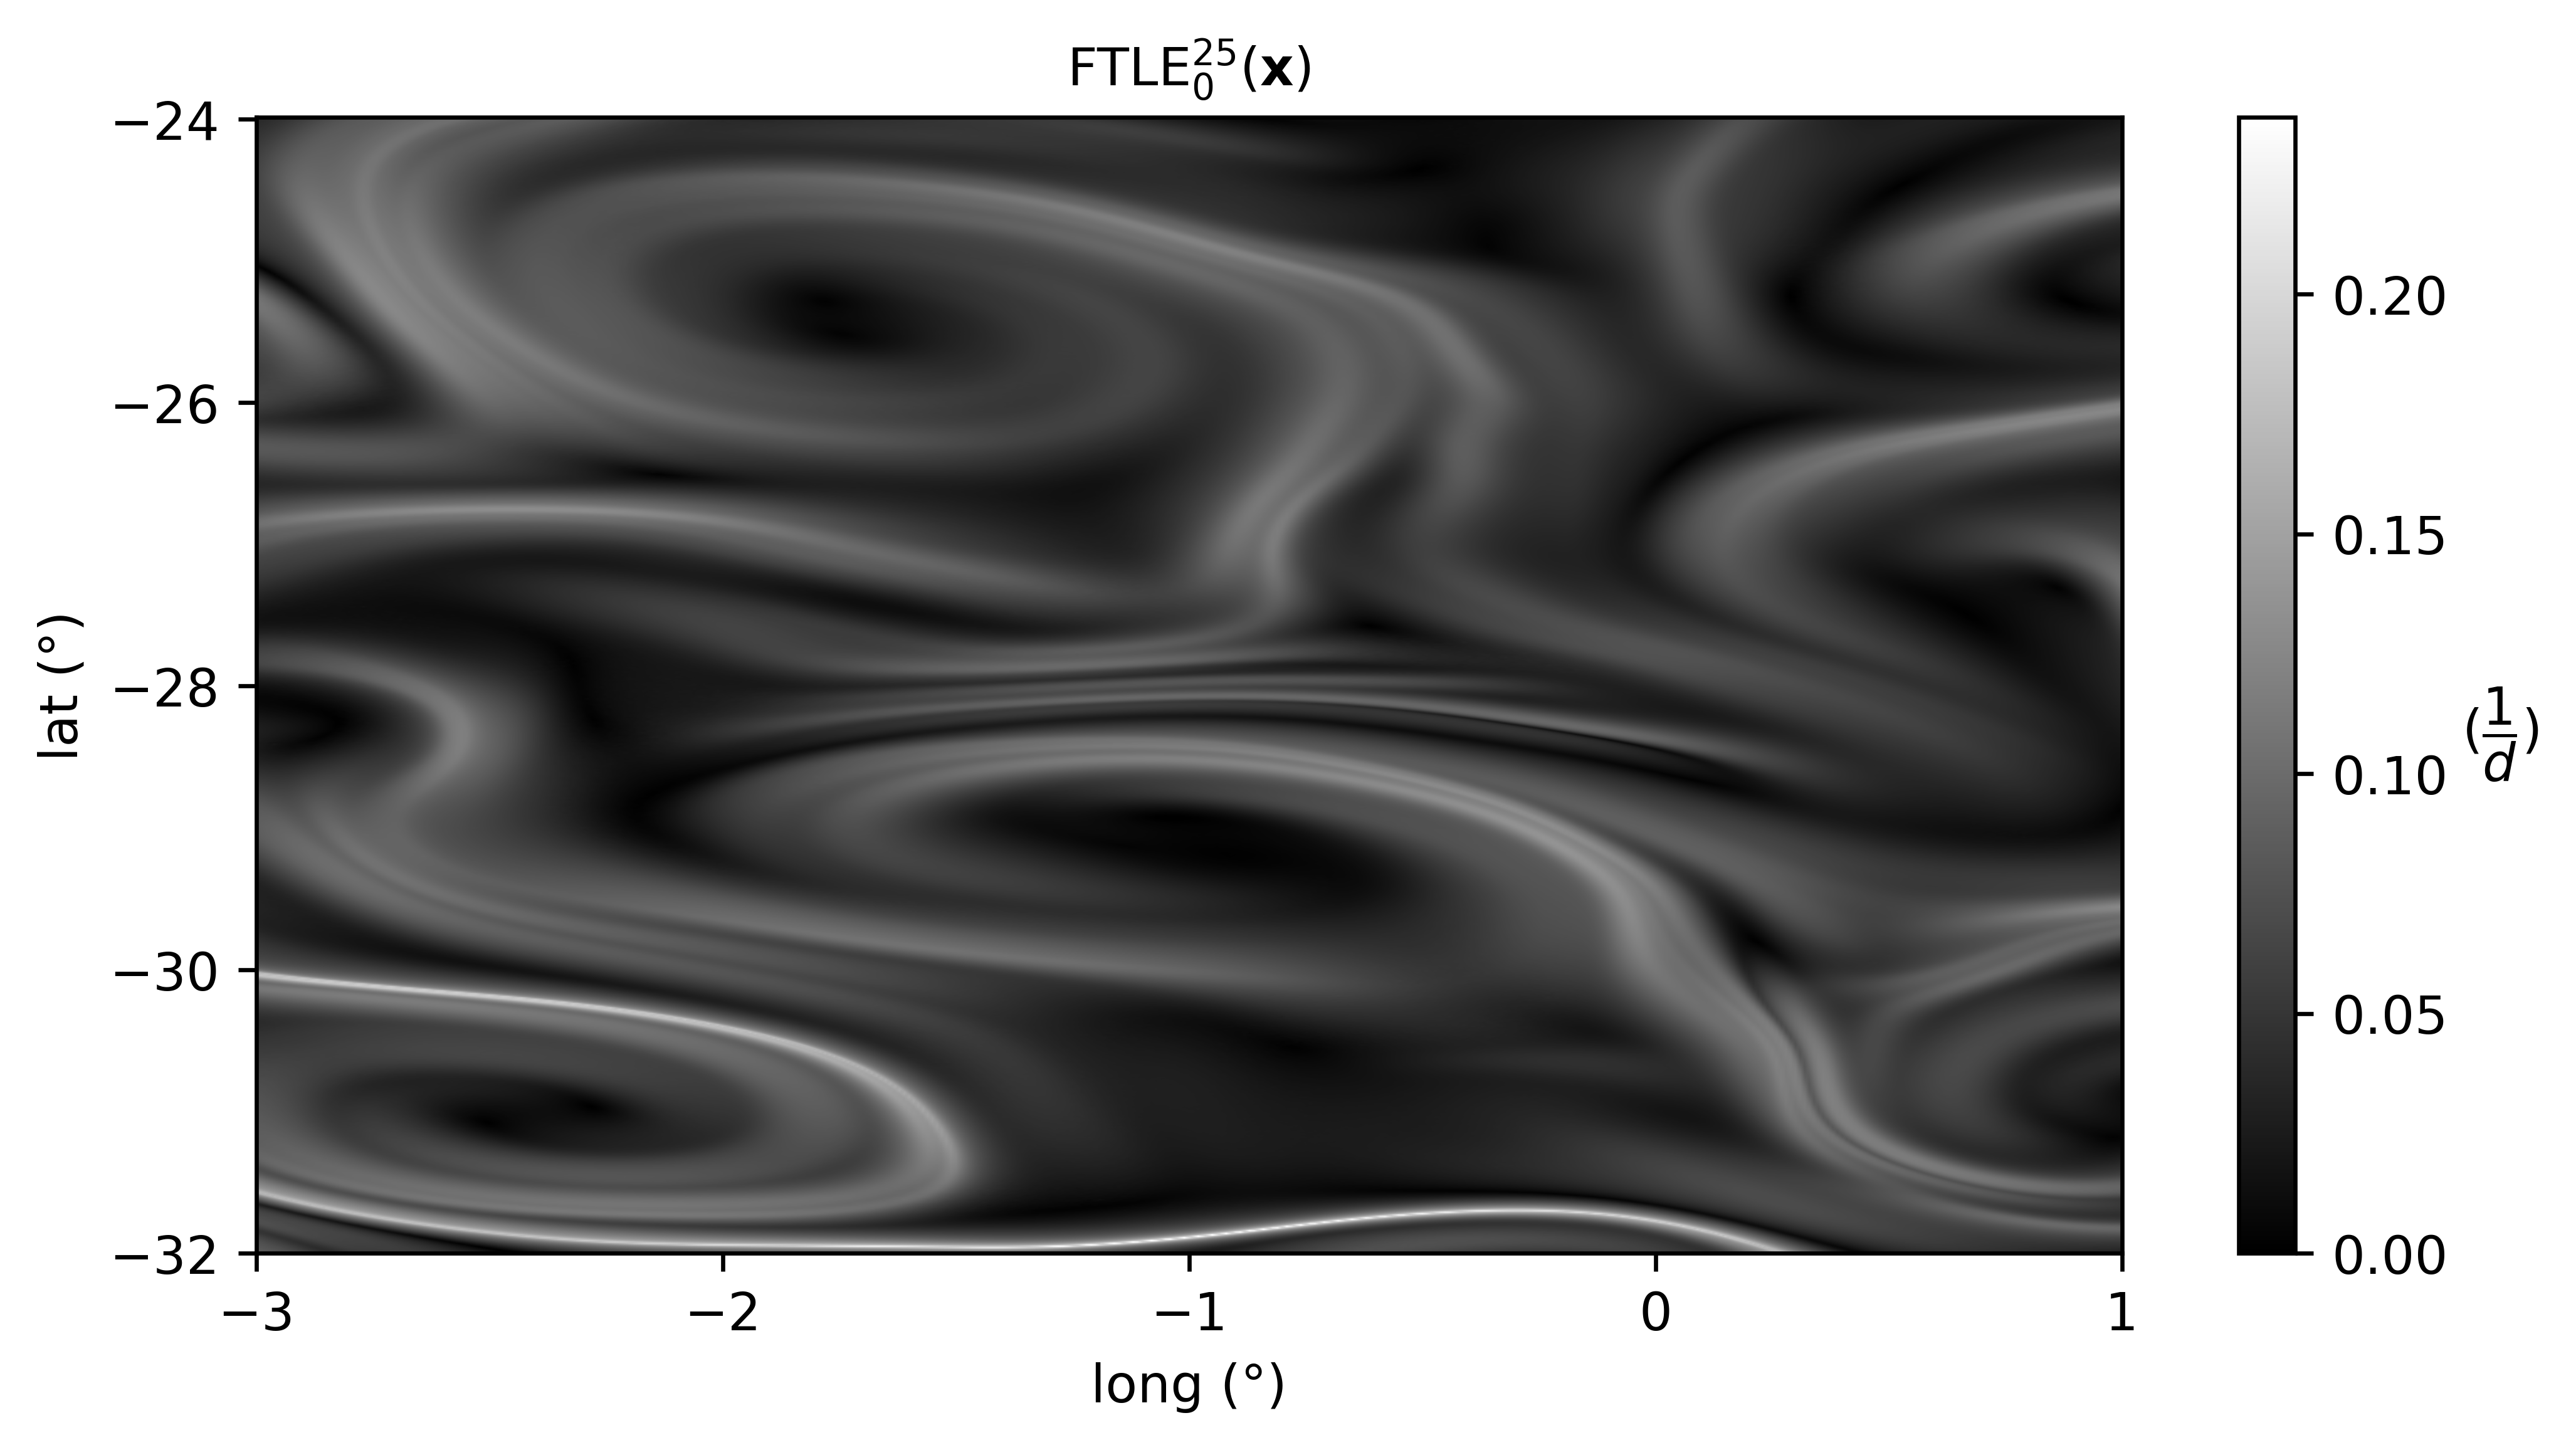

In [7]:
######################## PLOT RESULTS ########################
import matplotlib.pyplot as plt

# Figure/Axes
fig = plt.figure(figsize=(8, 4), dpi = 600)
ax = plt.axes()

# Contourplot of FTLE over meshgrid of initial conditions
cax = ax.contourf(X_domain, Y_domain, np.ma.masked_invalid(FTLE), cmap = "gist_gray", levels = 600)

# Axis Labels
ax.set_xlabel("long (°)", fontsize = 10)
ax.set_ylabel("lat (°)", fontsize = 10)

# Ticks
ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain)+0.1, 1))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain)+0.1, 2))

# Colorbar
cbar = fig.colorbar(cax, ticks = np.linspace(0, .4, 9))
cbar.ax.set_ylabel(r'$(\dfrac{1}{d})$', rotation = 0, labelpad = 10, fontsize = 10)

# Title
ax.set_title(r'$ \mathrm{FTLE}$'+f'$_{{{int(time[0])}}}^{{{int(time[-1])}}}$'+r'$(\mathbf{x})$', fontsize = 10)

plt.show()

The forward FTLE field is plotted with respect to the initial position of the particles. Repelling LCS are visible as ridges in the forward FTLE field, whereas trenches of FTLE field signal parabolic (jet-type) LCSs. An analogous statement holds for attracting LCS and the backward FTLE field. As a first approach, ridges of the FTLE field can be extracted using simple thresholding. This should already provide a good hint to the location of hyperbolic features.

FTLE ridges, however, are necessary but not sufficient conditions for hyperbolic LCS. Ridges of the FTLE field have also been related to regions of high shear. As a consequence the FTLE should only be considered as a first (and relatively rapid) approach for finding hyperbolic (repelling/attracting) LCS. More advanced methods such as the computation of the tensorlines associated to the eigenvalues of the Cauchy-Green strain tensor, should be used for a precise computation of hyperbolic LCS (see [HyperbolicLCS](../../HyperbolicLCS/Main/HyperbolicLCSAgulhas.ipynb)) [1, 2].

# References

[1] Haller, G. (2015). Lagrangian coherent structures. Annual Review of Fluid Mechanics, 47, 137-162.

[2] Haller, G., & Sapsis, T. (2011). Lagrangian coherent structures and the smallest finite-time Lyapunov exponent. Chaos: An Interdisciplinary Journal of Nonlinear Science, 21(2), 023115.